In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString, MultiLineString
from shapely import ops
import networkx as nx
import matplotlib.pyplot as plt
import folium
import pickle
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

['/Users/janhendrikwebert/maritime_route_prediction/notebooks', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../src/models', '../src/visualization', '../src/features', '../visualization', '../features']


In [3]:
# load network from pickle
fileObj = open('../models/networks/202204_waypoints_DP10_HDBSCAN30_stavanger_full_UTM.obj', 'rb')
network = pickle.load(fileObj)
fileObj.close()

In [21]:
network.prune_graph(4)

------------------------
Pruned Graph:
Number of nodes: 800 (28 isolated)
Number of edges: 2138
------------------------


In [29]:
mmsis = [network.significant_points.mmsi.unique()[3800]]  # 500, 200, 1700, 2900, 3800
for mmsi in mmsis:
    trajectory = network.trajectories.get_trajectory(mmsi)
    trajectory_points = trajectory.to_point_gdf()
    trajectory_points.reset_index(inplace=True)
    #path, evaluation_results = network.trajectory_to_path(trajectory)
    #path, evaluation_results = network.trajectory_to_path2(trajectory)
    #orig = path.orig.iloc[0]
    #dest = path.dest.iloc[-1]
    #dijkstra_path = network.dijkstra_shortest_path(orig, dest, weight='inverse_weight')

In [32]:
G = network.G_pruned.copy()
waypoints = network.waypoints.copy()
connections = network.waypoint_connections_pruned.copy()
points = trajectory.to_point_gdf()
mmsi = points.mmsi.unique()[0]

### GET START POINT ###
# map trajectory start point to the closest waypoint available
orig = points.iloc[0].geometry  # get trajectory start point
# find out if trajectory starts in a stop point
try:
    orig_speed = points.iloc[0:5].speed.mean()
    if orig_speed < 2:
        orig_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[0].lon, points.iloc[0].lat), 
                                                                    Point(points.iloc[40].lon, points.iloc[40].lat)) # get initial cog
        angle = (orig_cog - waypoints.cog_after + 180) % 360 - 180
        #mask = ((waypoints.speed < 2) & (np.abs(angle) < 45))
        mask = np.abs(angle) < 45
    else:
        orig_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[0].lon, points.iloc[0].lat), 
                                                                    Point(points.iloc[9].lon, points.iloc[9].lat)) # get initial cog
        angle = (orig_cog - waypoints.cog_after + 180) % 360 - 180
        mask = np.abs(angle) < 45  # only consider waypoints that have similar direction
except:
    orig_speed = points.iloc[0:2].speed.mean()
    orig_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[0].lon, points.iloc[0].lat), 
                                                                    Point(points.iloc[1].lon, points.iloc[1].lat)) # get initial cog
    angle = (orig_cog - waypoints.cog_after + 180) % 360 - 180
    mask = np.abs(angle) < 45  # only consider waypoints that have similar direction
distances = orig.distance(waypoints[mask].geometry)
masked_idx = np.argmin(distances)
orig_WP = waypoints[mask]['clusterID'].iloc[masked_idx]
# find trajectory point that is closest to the centroid of the first waypoint
# this is where we start measuring
orig_WP_point = waypoints[waypoints.clusterID==orig_WP]['geometry'].item()
idx_orig = np.argmin(orig_WP_point.distance(points.geometry))
# Now we have found the first waypoint and the first point on the trajectory closest to that waypoint

### GET END POINT ###
# map trajectory end point to the closest waypoint available
dest = points.iloc[-1].geometry  # get end point
try:
    dest_speed = points.iloc[-5:-1].speed.mean()
    if dest_speed < 2:
        mask = (waypoints.speed < 2)
    else:
        dest_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[-10].lon, points.iloc[-10].lat), 
                                                                    Point(points.iloc[-1].lon, points.iloc[-1].lat)) # get initial cog
        angle = (dest_cog - waypoints.cog_before + 180) % 360 - 180
        mask = np.abs(angle) < 45  # only consider waypoints that have similar direction
except:
    dest_speed = points.iloc[-3:-1].speed.mean()
    dest_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[-2].lon, points.iloc[-2].lat), 
                                                                Point(points.iloc[-1].lon, points.iloc[-1].lat)) # get initial cog
    angle = (dest_cog - waypoints.cog_before + 180) % 360 - 180
    mask = np.abs(angle) < 45  # only consider waypoints that have similar direction
distances = dest.distance(waypoints[mask].geometry)
masked_idx = np.argmin(distances)
dest_WP = waypoints[mask]['clusterID'].iloc[masked_idx]
# find trajectory point that is closest to the centroid of the last waypoint
# this is where we end measuring
dest_WP_point = waypoints[waypoints.clusterID==dest_WP]['geometry'].item()
idx_dest = np.argmin(dest_WP_point.distance(points.geometry))
# Now we have found the last waypoint and the last point on the trajectory closest to that waypoint
print(f'start: {orig_WP}, end: {dest_WP}')
print(orig_speed, orig_cog, dest_speed, dest_cog)

#### Find path between origin and destination
# find a path from start to end waypoint
path = [orig_WP]
current_WP = orig_WP

while path[-1] != dest_WP:
    # Check if a next path segment is available
    if len(list(G.neighbors(current_WP))) > 0:
        next_WP = current_WP  # if we don't find a next waypoint, the algorithm will terminate
        # check if there are any intersections between candidate waypoints and the trajectory
        candidate_WPs = G.neighbors(current_WP)
        candidate_WP_hulls = waypoints[waypoints.clusterID.isin(candidate_WPs)]['convex_hull']
        intersects = trajectory.distance(candidate_WP_hulls)<50
        # if we found waypoint intersections we look for the next waypoint among them
        if np.sum(intersects)>0:
            print('Waypoint intersections found. Finding closest neighbor...')
            shortest_edge_length = np.inf
            # try to find closest waypoint that is intersected by the trajectory and matches in direction
            for candidate_WP in G.neighbors(current_WP):
                print(f'Candidate: {candidate_WP}')
                # does the trajectory intersect the convex hull of the waypoint candidate?
                candidate_WP_hull = waypoints[waypoints.clusterID==candidate_WP]['convex_hull'].item()
                intersects = trajectory.distance(candidate_WP_hull)<50
                if intersects:
                    edge_length = G[current_WP][candidate_WP]['length']
                
                    # find trajectory point closest to current waypoint
                    current_WP_point = waypoints[waypoints.clusterID==current_WP]['geometry'].item()  # get coordinates of waypoint centroid
                    distances = points.distance(current_WP_point)  
                    p1_idx = np.argmin(distances)
                
                    # find trajectory point closest to candidate waypoint
                    candidate_WP_point = waypoints[waypoints.clusterID==candidate_WP]['geometry'].item()  # get coordinates of waypoint centroid
                    distances = points.iloc[p1_idx:-1].distance(candidate_WP_point)  
                    p2_idx = np.argmin(distances) + p1_idx
                    print(p1_idx, p2_idx)
                    if (p2_idx - p1_idx) <= 0:
                        print('going back is not allowed')
                        continue

                    # does the COG of trajectory and waypoint candidate match?
                    # compute trajectory COG close to candidate waypoint
                    p2_cog_before = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[p2_idx-5].lon, points.iloc[p2_idx-5].lat), 
                                                                                 Point(points.iloc[p2_idx].lon, points.iloc[p2_idx].lat))
                    # caution at the end of the trajectory not to run out of bounds
                    if len(points)-p2_idx > 5:
                        p2_cog_after = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[p2_idx].lon, points.iloc[p2_idx].lat), 
                                                                                    Point(points.iloc[p2_idx+5].lon, points.iloc[p2_idx+5].lat))
                    else:
                        p2_cog_after = p2_cog_before
                
                    # get candidate waypoint traffic direction both before and after waypoint passage
                    candidate_WP_cog_before = waypoints[waypoints.clusterID==candidate_WP]['cog_before'].item()
                    candidate_WP_cog_after = waypoints[waypoints.clusterID==candidate_WP]['cog_after'].item()
                
                    # compute angle between trajectory and waypoint candidate
                    angle_before = (p2_cog_before - candidate_WP_cog_before + 180) % 360 - 180
                    angle_after = (p2_cog_after - candidate_WP_cog_after + 180) % 360 - 180
                    print(intersects, edge_length)
                    print(f'trajectory COG: {p2_cog_before:.2f}, WP COG before: {candidate_WP_cog_before:.2f}, angle: {angle_before:.2f}')
                    print(f'trajectory COG: {p2_cog_after:.2f}, WP COG after: {candidate_WP_cog_after:.2f}, angle: {angle_after:.2f}')
                    if ((edge_length < shortest_edge_length) & ((np.abs(angle_before)<45 or np.abs(angle_after)<45))):
                        next_WP = candidate_WP
                        shortest_edge_length = edge_length
        else:
            print('No intersections found. Finding neighbor that minimises distance between trajectory and edge...')
            shortest_mean_distance_intersects = np.inf
            shortest_mean_distance_non_intersects = np.inf
            flag = False
            for candidate_WP in G.neighbors(current_WP):
                #print(f'Candidate: {candidate_WP}')
                # does the candidate have any neighbors that lead back to the trajectory?
                candidate_WP_hulls = waypoints[waypoints.clusterID.isin(G.neighbors(candidate_WP))]['convex_hull']
                intersects = trajectory.distance(candidate_WP_hulls)<50

                # calculate mean distance between the trajectory and the edge between current and candidate waypoint
                # get edge between current and candidate waypoint
                edge = connections[(connections['from'] == current_WP) & (connections['to'] == candidate_WP)].geometry.item()
                # get trajectory segment between the two waypoints
                # find trajectory point closest to current waypoint
                current_WP_point = waypoints[waypoints.clusterID==current_WP]['geometry'].item()  # get coordinates of waypoint centroid
                distances = points.distance(current_WP_point)  
                p1_idx = np.argmin(distances)
                # find trajectory point closest to candidate waypoint
                candidate_WP_point = waypoints[waypoints.clusterID==candidate_WP]['geometry'].item()  # get coordinates of waypoint centroid
                distances = points.iloc[p1_idx:-1].distance(candidate_WP_point)  
                p2_idx = np.argmin(distances) + p1_idx
                if (p2_idx - p1_idx) <= 0:
                        print('going back is not allowed')
                        continue
                # compute mean distance between trajectory segment and edge
                mean_distance = points[p1_idx:p2_idx].distance(edge).mean()
                # compute trajectory COG close to candidate waypoint
                p2_cog_before = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[p2_idx-5].lon, points.iloc[p2_idx-5].lat), 
                                                                                 Point(points.iloc[p2_idx].lon, points.iloc[p2_idx].lat))
                # caution at the end of the trajectory not to run out of bounds
                if len(points)-p2_idx > 5:
                    p2_cog_after = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[p2_idx].lon, points.iloc[p2_idx].lat), 
                                                                                    Point(points.iloc[p2_idx+5].lon, points.iloc[p2_idx+5].lat))
                else:
                    p2_cog_after = p2_cog_before
                # get candidate waypoint traffic direction both before and after waypoint passage
                candidate_WP_cog_before = waypoints[waypoints.clusterID==candidate_WP]['cog_before'].item()
                candidate_WP_cog_after = waypoints[waypoints.clusterID==candidate_WP]['cog_after'].item()
                angle_before = (p2_cog_before - candidate_WP_cog_before + 180) % 360 - 180
                angle_after = (p2_cog_after - candidate_WP_cog_after + 180) % 360 - 180

                if np.sum(intersects)>0:
                    flag=True  # found a point that leads back to path
                    if ((mean_distance < shortest_mean_distance_intersects) & ((np.abs(angle_before)<90 or np.abs(angle_after)<90))):
                        next_WP = candidate_WP
                        shortest_mean_distance_intersects = mean_distance
                else:
                    if ((mean_distance < shortest_mean_distance_non_intersects) & ((np.abs(angle_before)<90 or np.abs(angle_after)<90)) & (flag==False)):
                        next_WP = candidate_WP
                        shortest_mean_distance_non_intersects = mean_distance
            
        if next_WP == current_WP:
            print('Got stuck. Terminating early...')
            message = 'early_termination'
            break
        else:
            path.append(next_WP) # append next waypoint to path
            G.remove_node(current_WP)  # drop current waypoint from graph to avoid going in circles
            current_WP = next_WP
        print(f'Found next waypoint: {next_WP}')
        print('==============================================')
    else:
        print('No more adjacent waypoints. Terminating...')
        message = 'no_path'
        break
    message = 'success'

# make trajectory from path
path_df = pd.DataFrame(columns=['mmsi', 'orig', 'dest', 'geometry', 'message'])
for j in range(0, len(path)-1):
    edge = connections[(connections['from'] == path[j]) & (connections['to'] == path[j+1])].geometry.item()
    temp = pd.DataFrame([[mmsi, path[j], path[j+1], edge, message]], columns=['mmsi', 'orig', 'dest', 'geometry', 'message'])
    path_df = pd.concat([path_df, temp])
path_df = gpd.GeoDataFrame(path_df, geometry='geometry', crs=network.crs)

###########
# evaluate goodness of fit
###########
eval_points = points.iloc[idx_orig:idx_dest]  # the subset of points we are evaluating against
multi_line = MultiLineString(list(path_df.geometry))
edge_sequence = ops.linemerge(multi_line)  # merge edge sequence to a single linestring
distances = eval_points.distance(edge_sequence)  # compute distance between edge sequence and trajectory points
mean_dist = distances.mean()
median_dist = distances.median()
max_dist = distances.max()
evaluation_results = pd.DataFrame({'mmsi':mmsi,
                                   'mean_dist':mean_dist,
                                   'median_dist':median_dist,
                                   'max_dist':max_dist,
                                   'distances':[distances.tolist()],
                                   'message':message}
                                 )

start: 351, end: 324
4.080965194760257 221.8387142939098 3.723725808535666 231.9716816180771
Waypoint intersections found. Finding closest neighbor...
Candidate: 352
0 6
True 724.5310116076527
trajectory COG: 231.11, WP COG before: 234.62, angle: -3.50
trajectory COG: 231.11, WP COG after: 242.71, angle: -11.60
Candidate: 321
0 6
True 988.7083941095001
trajectory COG: 231.11, WP COG before: 61.34, angle: 169.77
trajectory COG: 231.11, WP COG after: 62.77, angle: 168.35
Candidate: 322
0 0
going back is not allowed
Candidate: 323
0 6
True 1161.804060675921
trajectory COG: 231.11, WP COG before: 253.56, angle: -22.45
trajectory COG: 231.11, WP COG after: 66.01, angle: 165.11
Found next waypoint: 352
Waypoint intersections found. Finding closest neighbor...
Candidate: 316
6 6
going back is not allowed
Candidate: 321
6 6
going back is not allowed
Candidate: 323
6 6
going back is not allowed
Got stuck. Terminating early...


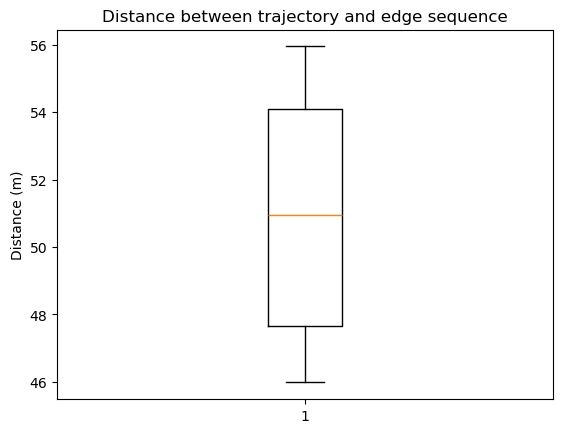

mmsi  mean_dist  median_dist   max_dist  \
0  257390900_357_2022-04-26 10:34:29  50.908981    50.935427  55.948011   

                                           distances  
0  [52.45961212143442, 45.98037509325609, 46.5817...

In [33]:
# plot metrics
plt.boxplot(evaluation_results.distances)
plt.title('Distance between trajectory and edge sequence')
plt.ylabel('Distance (m)')
plt.show()
evaluation_results.head()


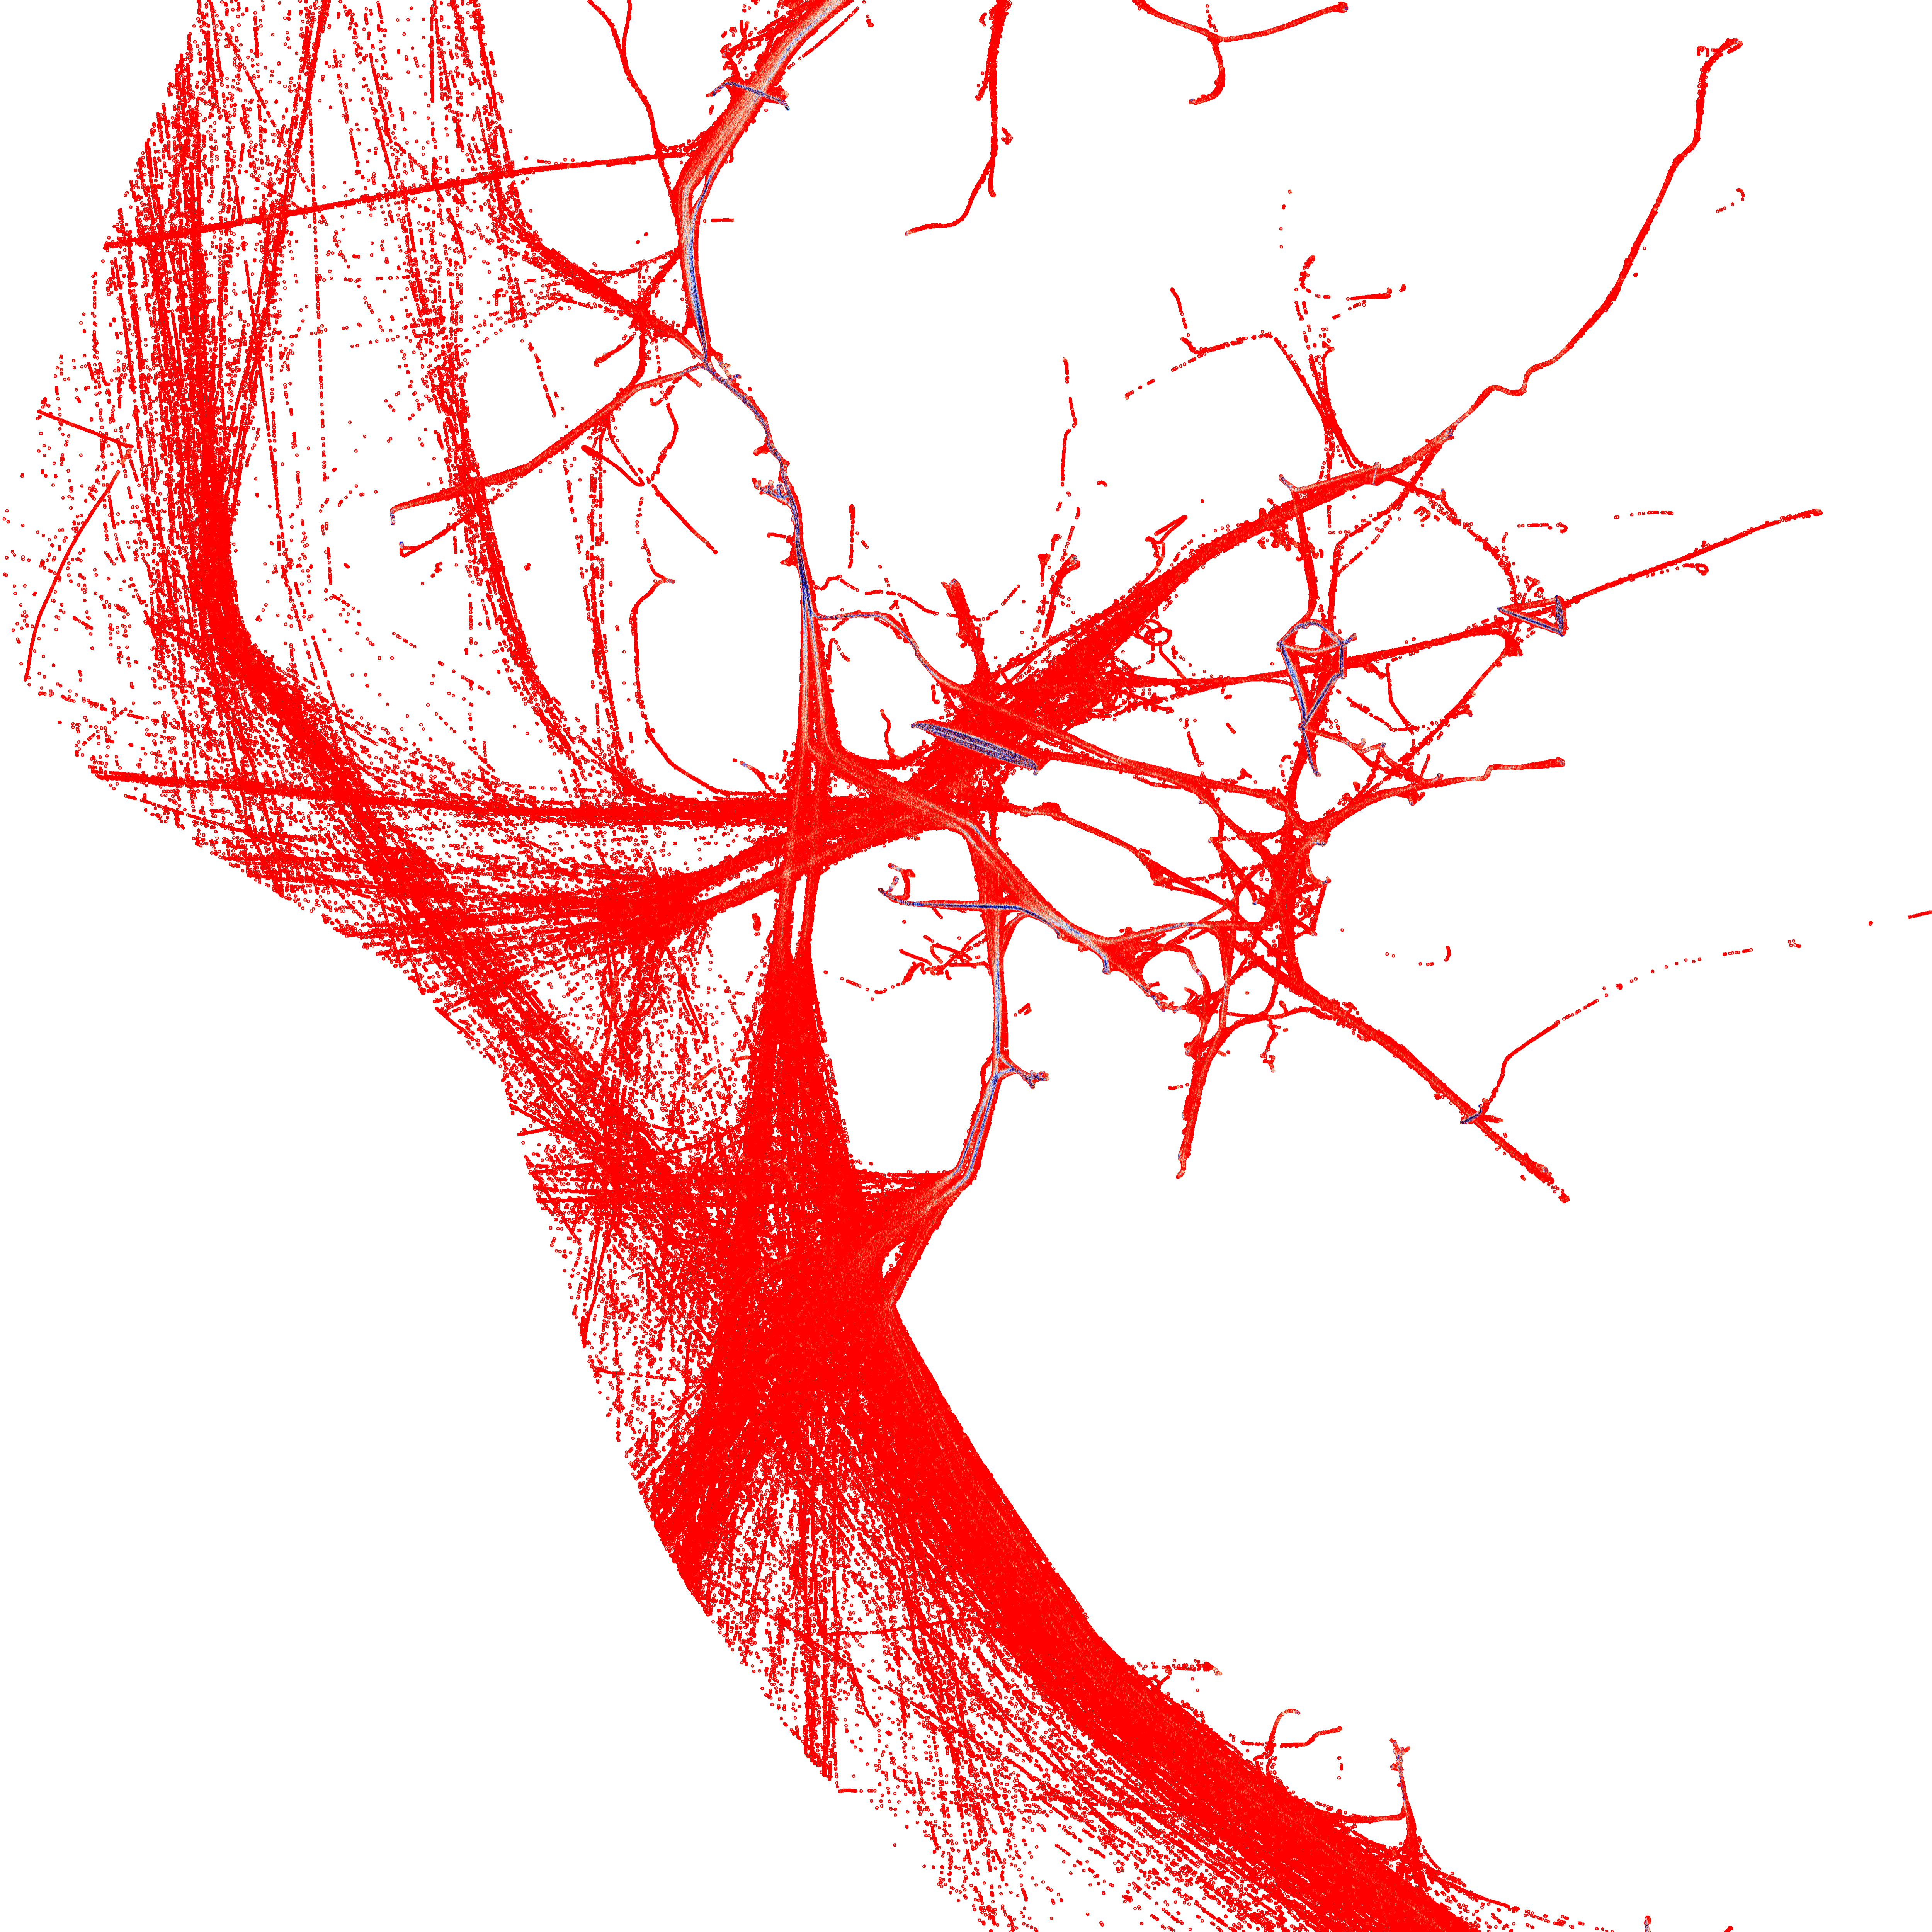

In [35]:
# Generate plot
map = network.map_graph(pruned=True)
map = trajectory.to_line_gdf()[['geometry', 'mmsi']].explore(m=map, style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
                                                               name=mmsi)
map = trajectory_points[['geometry', 'mmsi']].explore(m=map, marker_kwds={'radius':1}, 
                                                        style_kwds={'color':'black', 'fillColor':'black', 'fillOpacity':1}, 
                                                        name=mmsi+' points')
#map = eval_points.reset_index()[['geometry', 'mmsi']].explore(m=map, color='grey', marker_kwds={'radius':1})
map = path_df.explore(m=map, color='yellow', name=mmsi+' path')
#map = dijkstra_path.explore(m=map, color='orange', name=mmsi+' dijkstra path')
#map = waypoints[waypoints.clusterID.isin([359, 546])]['geometry'].explore(m=map)
folium.LayerControl().add_to(map)

map

In [14]:
map.save('dummy.html')